# Data Wrangling

In [90]:
import pandas as pd
import sys
import os

# Agrega el path al directorio raíz del proyecto
sys.path.append(os.path.abspath(".."))

from scripts.blackAndWhite import BlackAndWhite

In [91]:
# Extraer datos de un archivo CSV
df_eventos = pd.read_csv('../data/raw/eventos.csv')
df_normal = pd.read_csv('../data/raw/normal.csv')

## Nulos

In [92]:
# Elimina todos los registros donde Start_Frame es nulo
df_eventos = df_eventos[df_eventos['Start_Frame'].notnull()]

In [93]:
# Rellena los nulos con 0
df_eventos = df_eventos.fillna(0)

In [94]:
df_eventos.shape

(340, 5)

## Duplicados

In [95]:
# Elimina el Video Robbery138_x264.mp4
df_eventos = df_eventos[df_eventos['Video'] != 'Robbery138_x264.mp4']

In [96]:
df_eventos.shape

(339, 5)

## Outliers

In [97]:
import cv2
# Crea una función para ver la duración de cada video 
def duracion_video(video, evento):
    video_path = f"../data/Anomaly-Detection-Dataset/Anomaly-Videos/{evento}/{video}"
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    return frame_count

In [98]:
# df_eventos
df_eventos['duracion'] = df_eventos['End_Frame'] - df_eventos['PCB']

In [99]:
# df_normal
df_normal['duracion'] = df_normal.apply(lambda x: duracion_video(x['Video'], 'Normal'), axis=1)

## Unión

In [100]:
# Une los dos dataframes
df = pd.concat([df_eventos, df_normal])

In [101]:
df[df['Evento'] == 'Normal'].shape

(396, 6)

In [102]:
df.shape

(735, 6)

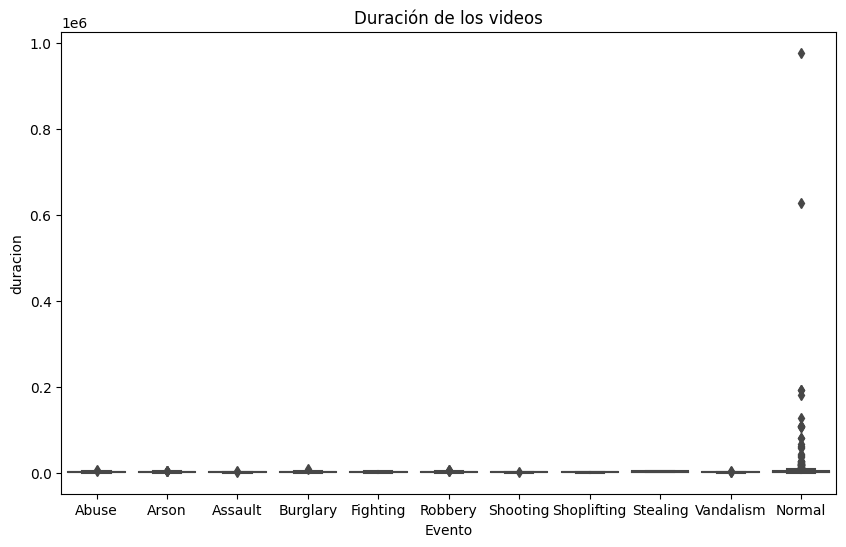

In [103]:
# Boxplot de la duración de los videos
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(x='Evento', y='duracion', data=df)
plt.title('Duración de los videos')
plt.show()

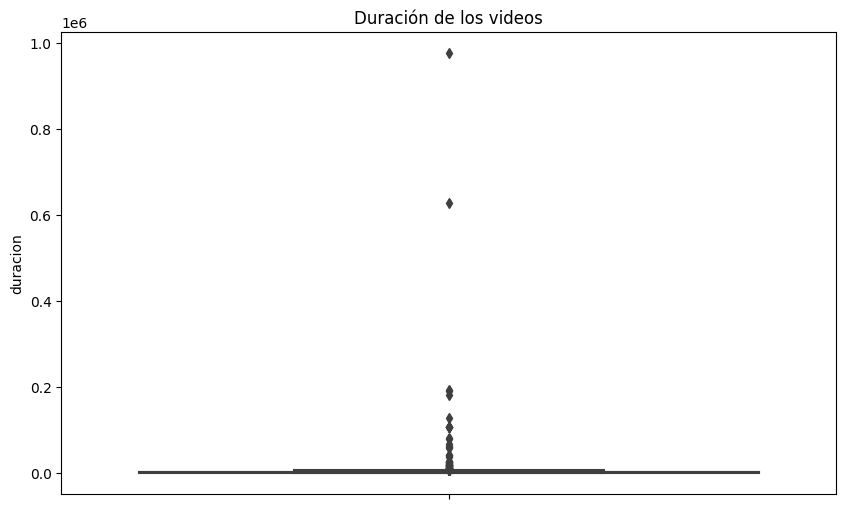

In [104]:
plt.figure(figsize=(10, 6))
sns.boxplot( y='duracion', data=df)
plt.title('Duración de los videos')
plt.show()

In [105]:
def eliminar_outliers(df, columna='duracion'):
    Q1 = df[columna].quantile(0.25)
    Q3 = df[columna].quantile(0.75)
    IQR = Q3 - Q1

    filtro = (df[columna] >= (Q1 - 1.5 * IQR)) & (df[columna] <= (Q3 + 1.5 * IQR))
    return df[filtro]

In [106]:
df = eliminar_outliers(df)
df.shape

(661, 6)

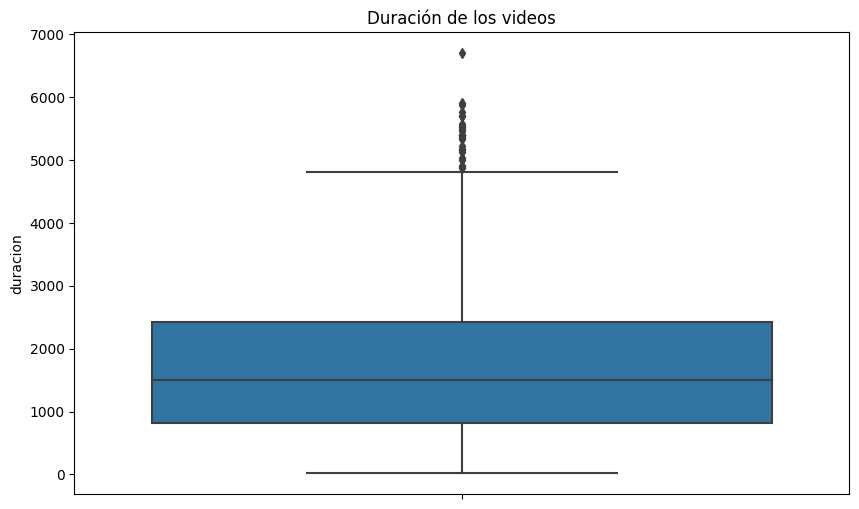

In [107]:
plt.figure(figsize=(10, 6))
sns.boxplot( y='duracion', data=df)
plt.title('Duración de los videos')
plt.show()

## BlackAndWhite

In [114]:
bw = BlackAndWhite("../data/Anomaly-Detection-Dataset/Anomaly-Videos", df)

In [115]:
df_bw = bw.encontrar_bw()

[Blanco y Negro] Video: Arson006_x264.mp4
[Blanco y Negro] Video: Arson036_x264.mp4
[Blanco y Negro] Video: Assault014_x264.mp4
[Blanco y Negro] Video: Assault017_x264.mp4
[Blanco y Negro] Video: Burglary022_x264.mp4
[Blanco y Negro] Video: Stealing020_x264.mp4
[Blanco y Negro] Video: Stealing061_x264.mp4
[Blanco y Negro] Video: Stealing075_x264.mp4
[Blanco y Negro] Video: Stealing102_x264.mp4


In [116]:
# Drop df_bw de df
df = df[~df['Video'].isin(df_bw['Video'])]

In [117]:
df_bw.shape

(9, 6)

In [118]:
df.shape

(652, 6)

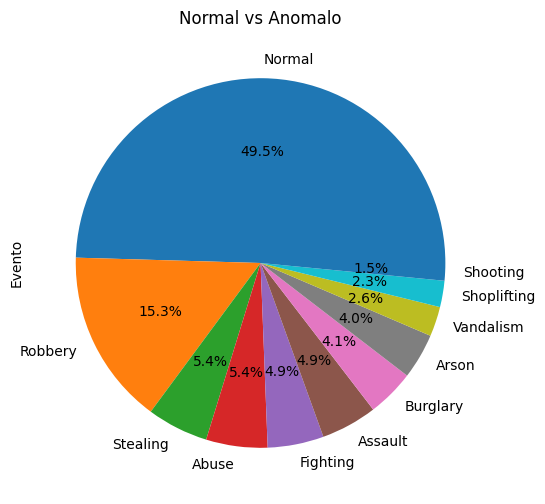

In [119]:
# Pie chart Normal vs Anomalo
plt.figure(figsize=(10, 6))
df['Evento'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title('Normal vs Anomalo')
plt.show()

In [122]:
normal_count = df[df['Evento'] == 'Normal'].shape[0]
anomalo_count = df[df['Evento'] != 'Normal'].shape[0]

In [123]:
print(f'Normal: {normal_count}')
print(f'Anomalo: {anomalo_count}')

Normal: 323
Anomalo: 329


In [125]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 652 entries, 0 to 395
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Video        652 non-null    object 
 1   Evento       652 non-null    object 
 2   PCB          652 non-null    float64
 3   Start_Frame  652 non-null    float64
 4   End_Frame    652 non-null    float64
 5   duracion     652 non-null    float64
dtypes: float64(4), object(2)
memory usage: 35.7+ KB


In [126]:
# Revisar si en las columnas PCB, Start_Frame, End_Frame, duracion hay valores negativos
for col in ['PCB', 'Start_Frame', 'End_Frame', 'duracion']:
    print(f'{col}: {df[df[col] < 0].shape[0]}')

PCB: 0
Start_Frame: 0
End_Frame: 0
duracion: 0


In [127]:
# Verificar si en las columnas hay valor no int
for col in ['PCB', 'Start_Frame', 'End_Frame', 'duracion']:
    print(f'{col}: {df[~df[col].apply(lambda x: isinstance(x, int))].shape[0]}')

PCB: 652
Start_Frame: 652
End_Frame: 652
duracion: 652


In [128]:
# Transformar las columnas PCB, Start_Frame, End_Frame, duracion a int
df['PCB'] = df['PCB'].astype(int)
df['Start_Frame'] = df['Start_Frame'].astype(int)
df['End_Frame'] = df['End_Frame'].astype(int)
df['duracion'] = df['duracion'].astype(int)

/var/folders/sy/fk_t21qs7qv3xc99jxz4q50m0000gn/T/ipykernel_66921/1463249866.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['PCB'] = df['PCB'].astype(int)
/var/folders/sy/fk_t21qs7qv3xc99jxz4q50m0000gn/T/ipykernel_66921/1463249866.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Start_Frame'] = df['Start_Frame'].astype(int)
/var/folders/sy/fk_t21qs7qv3xc99jxz4q50m0000gn/T/ipykernel_66921/1463249866.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

In [129]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 652 entries, 0 to 395
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Video        652 non-null    object
 1   Evento       652 non-null    object
 2   PCB          652 non-null    int64 
 3   Start_Frame  652 non-null    int64 
 4   End_Frame    652 non-null    int64 
 5   duracion     652 non-null    int64 
dtypes: int64(4), object(2)
memory usage: 35.7+ KB


In [130]:
df.to_csv('../data/clean/data.csv', index=False)